# Estimation of Direction of Arrival (DOA) for First Order Ambisonic Audio Files using Artificial Neural Networks

**Pedro Pablo Lucas Bravo**

**pedropl@uio.no**

Return to [file.ipybn](file.ipynb)

Go back to [feature_extraction.ipybn](feature_extraction.ipynb)

Continue to [inference.ipybn](inference.ipynb)

# Training

**Before running**: If you DONT want to save the models set the next vatiable to FALSE.

In [1]:
save = True

## Packages and Utilitiy Functions

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import joblib

from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_validate

import time

start_time = time.time()

#Taken from: https://stackoverflow.com/questions/2827393/angles-between-two-n-dimensional-vectors-in-python
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

## Load Training Features from CSV File

In [3]:
#Load from file
print('Loading features...')
dataset = pd.read_csv('features_train.csv')
num_features = 768
features = dataset.iloc[:,0:num_features].to_numpy()
target = np.zeros((features.shape[0],3))
target[:,0] = dataset['x'] 
target[:,1] = dataset['y']
target[:,2] = dataset['z']
print(features.shape)
print(target.shape)
print('Done!')

Loading features...
(15798, 768)
(15798, 3)
Done!


## Training

The training process includes a pipeline with 3 steps: 

1. A 'whitening' transformation using a StandardScaler.
2. Dimensionality reduction using Principal Component Analysis(PCA) to take 40 component.
3. A Multi-layer Perceptron regressor with 2 hidden layers (50 and 25 respectively) with iteration limit of 500, a logistic activation function, learning rate of 0.0001 (learning rate is constant), tolerance for converging of 0.00001, a L2 regularization parameter alpha of 0.1 to avoid overfitting, and the Adam optimization algorithm as solver.

Before the training, this pipeline is tested with a repeated k-fold validation (k = 5 with 5 repetitions) strategy to check relevant scores for the application. To arrive to this pipeline and network architecture, I tested several approaches regarding feature extraction and pipeline by using a Grid Search, specially in terms of hyperparameters for the ANN regarding hidden layers, activation function, and alpha; also training several PCA components. Part of these experiments are found in the [experiments](./experiments) folder (Remember that the notebooks here will not run unless they are in the root folder).

### Explained Variance for PCA

For chosing the number of components for PCA. The explained variance was taken into accounto and the 'Elbow method' was applied to keep a certain amount of variance for the training process. The next section shows the plot that helps to find the value, which was 40 components.

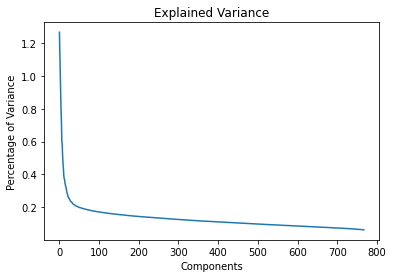

In [14]:
pipe_PCA = Pipeline([
        ('scaler', StandardScaler()),
        ('dim_red', PCA(n_components = 768))])
pipe_PCA.fit(features)
%matplotlib inline
plt.plot(pipe_PCA.get_params()['steps'][1][1].explained_variance_ratio_ * 100)
plt.title('Explained Variance')
plt.xlabel('Components')
plt.ylabel('Percentage of Variance')
#plt.savefig('./output/pca_variance.pdf')
plt.show()

### Cross-validation

In [5]:

print('Start Validation...\n')
#creating pipeline
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('dim_red', PCA(n_components = 40)),
        ('regressor', MLPRegressor(hidden_layer_sizes=(50, 25), max_iter=500, activation='logistic', verbose=False, random_state = 1, learning_rate_init = 0.0001, tol = 0.00001, alpha = 0.1))
        ])

#Perform cross-validation
rkf = RepeatedKFold(n_splits=5, n_repeats=5)

#initializing and running the cross validator with pipe, features, labels, scores, and kfold object
scores = cross_validate(pipe, features, target, cv=rkf, scoring=('neg_mean_squared_error', 'neg_mean_absolute_error', 'neg_median_absolute_error', 'r2'),return_train_score=True)

#print(scores,'\n')
print('Mean Squared Error mean and variance', -np.mean(scores['test_neg_mean_squared_error']),np.var(scores['test_neg_mean_squared_error']))
print('Mean Absolute Error mean and variance', -np.mean(scores['test_neg_mean_absolute_error']),np.var(scores['test_neg_mean_absolute_error']))
print('Median Absolute Error mean and variance', -np.mean(scores['test_neg_median_absolute_error']),np.var(scores['test_neg_median_absolute_error']))
print('R2 mean and variance', np.mean(scores['test_r2']),np.var(scores['test_r2']),'\n')

print('Done!')



Start Validation...

Mean Squared Error mean and variance 0.12726583751465803 7.314085693343502e-06
Mean Absolute Error mean and variance 0.2647714426842764 6.010623667684166e-06
Median Absolute Error mean and variance 0.20662328671238353 6.147080624115529e-06
R2 mean and variance 0.5799225189834 6.434772412392846e-05 

Done!


### Training

In [6]:
#training the pipeline
pipe.fit(features, target)

Pipeline(steps=[('scaler', StandardScaler()), ('dim_red', PCA(n_components=40)),
                ('regressor',
                 MLPRegressor(activation='logistic', alpha=0.1,
                              hidden_layer_sizes=(50, 25),
                              learning_rate_init=0.0001, max_iter=500,
                              random_state=1, tol=1e-05))])

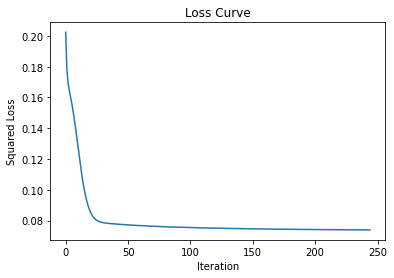

In [15]:
#plotting the loss curve over training iteration 
plt.plot(pipe.get_params()['steps'][2][1].loss_curve_)
plt.title('Loss Curve')
plt.xlabel('Iteration')
plt.ylabel('Squared Loss')
#plt.savefig('./output/loss_curve.pdf')
plt.show()

## Saving the Model

In [8]:
if save:
    #saving the model to file
    joblib_file = "doa_model.pkl"
    joblib.dump(pipe, joblib_file)

## Testing the Model

For this testing a different database is used. The database is separated in training and testing. In the [feature_extraction.ipybn](feature_extraction.ipynb) notebook the testing data is also transformed and saved so that it can be easyly and rapidly retrived for testing purposes. Here I load that data, get a prediction from it, and compare in terms of performance metrics and the delta angle between the actual DOA and the estimated DOA.

### Loading Test Data

In [9]:
#Load from file
print('Loading features...')
dataset_test = pd.read_csv('features_test.csv')
num_features = 768
features_test = dataset_test.iloc[:,0:num_features].to_numpy()
target_test = np.zeros((features_test.shape[0],3))
target_test[:,0] = dataset_test['x'] 
target_test[:,1] = dataset_test['y']
target_test[:,2] = dataset_test['z']
print(features_test.shape)
print(target_test.shape)
print('Done!')

Loading features...
(3974, 768)
(3974, 3)
Done!


### Restoring the Model from File

In [10]:
#restoring the classifier model from file
restored_model = joblib.load(joblib_file)

### Predicting

In [11]:
#Predicting from the testing data
target_pred = restored_model.predict(features_test)

### Performance Metrics on Testing Data

It shows a plot with the performance of the ANN through the iterations, which converges fast to the best model. Also, this metrics are based on the error per each component (x, y, z) that represents the DOA vector. The last metric considers a different parameter which is the angle between the actual and the estimated vector in degrees, it is shown the average error.

In [12]:
#computing a set of performance metrics
def show_metrics(target_test, target_pred):
    #mean squared error (lower the better)
    print('Mean squared error: %.4f'% sklearn.metrics.mean_squared_error(target_test, target_pred))

    #mean absolute error (lower the better)
    print('Mean absolute error: %.4f'% sklearn.metrics.mean_absolute_error(target_test, target_pred))

    #median absolute error (lower the better)
    print('Median absolute error: %.4f'% sklearn.metrics.median_absolute_error(target_test, target_pred))

    #coefficient of determination (r2 score): 1 is perfect prediction (it can get arbitrary negative)
    print('Coefficient of determination (R2 score): %.4f'% sklearn.metrics.r2_score(target_test, target_pred))

    #explained variance score: 1 is perfect prediction (it can get arbitrary worse)
    print('Explained variance score: %.4f'% sklearn.metrics.explained_variance_score(target_test, target_pred))

    #this is is a better represenation of the r2 score when working with multiple outputs
    #as it provides a value for each target value
    print('R2 score on individual targets [x, y, z]',sklearn.metrics.r2_score(target_test, target_pred, multioutput='raw_values'), '\n')

    #####----- Delta angle between actual DOA and estimated DOA
    deg = []
    for d in range(target_test.shape[0]):
        deg = np.append(deg, np.rad2deg(angle_between(target_test[d], target_pred[d])))
    print('MEAN ANGLE ERROR: %.4f'% np.mean(deg), 'Degrees\n')

print('PERFORMANCE METRICS ON TESTING DATA\n')
show_metrics(target_test, target_pred)

PERFORMANCE METRICS ON TESTING DATA

Mean squared error: 0.1155
Mean absolute error: 0.2518
Median absolute error: 0.1966
Coefficient of determination (R2 score): 0.6136
Explained variance score: 0.6138
R2 score on individual targets [x, y, z] [0.66936782 0.68238116 0.48891671] 

MEAN ANGLE ERROR: 30.2354 Degrees



### Performance Metrics on Training Data

This metrics will be obtained with the training data in order to stablish comparisions between cross-validation, testing, and training sets.

In [13]:
#Predicting from the testing data
target_pred_train = restored_model.predict(features)

print('PERFORMANCE METRICS ON TRAINING DATA\n')
show_metrics(target, target_pred_train)

print('TOTAL EXECUTION TIME: ', str(time.time() - start_time), ' sec')

PERFORMANCE METRICS ON TRAINING DATA

Mean squared error: 0.1249
Mean absolute error: 0.2616
Median absolute error: 0.2032
Coefficient of determination (R2 score): 0.5883
Explained variance score: 0.5884
R2 score on individual targets [x, y, z] [0.645721   0.6469887  0.47206668] 

MEAN ANGLE ERROR: 31.6975 Degrees

TOTAL EXECUTION TIME:  381.2887952327728  sec


Return to [file.ipybn](file.ipynb)

Go back to [feature_extraction.ipybn](feature_extraction.ipynb)

Continue to [inference.ipybn](inference.ipynb)